In [1]:
import os
os.chdir("../src/expB/")

import sys
import time
import copy
import random
import argparse

from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter


import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import datasets

import PIL

import matplotlib
from mpl_toolkits import mplot3d
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

import seaborn as sns

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, classification_report

from tqdm import tqdm

sys.path.append("../src/expB/")
from spheres_v2 import RandomSphere
from ptcifar.models import *
from learn_mfld_distance import train, test
from myNNs import *

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)


# Distance Learner for Adversarial Examples

Steps:

1. Train distance function with multiple spheres.
2. Construct a classifier which classifies based on the closest distance to the spheres.
3. Compare this to a standard classifier which learns the classification task directly (instead of learning distance functions).<br>
    3.1. Visualization at lower n's and k's for both classifiers<br>
    3.2. None of these class for distance regressor. Evaluate at high sigma's<br>
    3.3. Standard classifier with none of these class and compare with 3.2<br> -- naive and smarter sampling
4. concentric spheres -- std. clf. recreate the paper first, then move to our setting.
5. Adversarial attacks can be detected as points which are at least a threshold distance from the closest manifold.
6. Compare adversarial robustness via above method and current adversarial robustness methods on classifiers (e.g. Madry et.al’s adversarial training).
7. Run above on different synthetic manifolds.Run above on real datasets: MNIST, Cifar.

## 1. Train distance function with multiple spheres.

### 1.1 Generate the dataset




In [ ]:
# %run spheres_v2.py --twospheres --config data_configs/2sphere_expC_k2n2_config.json --save_dir /azuredrive/datasets/expC/2spheres_k2n2/






In [ ]:
# only run this cell for if you want to train std. clf. with off mfld label
# and smart off mfld. data augmentation
## NOTE: Under construction!! (14/06/21)



# train_set.class_labels[train_set.]

### 1.2 Training a Distance Regressor on the generated 2spheres dataset

In [2]:
%run -i learn_mfld_distance.py --train --specs ./expt_specs/specs_distlearn_2spheres_expC_train_14062021.json




100%|██████████| 500/500 [1:37:27<00:00, 11.69s/it]


In [4]:
epoch_wise_logits_fn = "/azuredrive/dumps/expC_dist_learner_for_adv_ex/k2n2/actual_dist_learner_w_masked_mse/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=2;k=2;actual_distance}/epoch_wise_val_logits.pt"
epoch_wise_logits = torch.load(epoch_wise_logits_fn)

epoch_wise_targets_fn = "/azuredrive/dumps/expC_dist_learner_for_adv_ex/k2n2/actual_dist_learner_w_masked_mse/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=2;k=2;actual_distance}/epoch_wise_val_targets.pt"
epoch_wise_targets = torch.load(epoch_wise_targets_fn)








In [5]:
epoch_wise_logits.shape

torch.Size([500, 20000, 2])

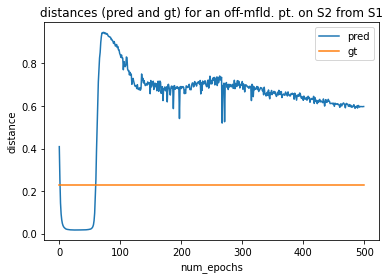

In [6]:
plt.plot(epoch_wise_logits[:, 0, 1], label="pred")
plt.plot(epoch_wise_targets[:, 0, 1], label="gt")
plt.xlabel("num_epochs")
plt.ylabel("distance")
plt.title("distances (pred and gt) for an off-mfld. pt. on S2 from S1")
plt.legend()
plt.show()


(array([8730., 1270.,  201., 1416., 1562., 1295., 1392., 1704., 2084.,
         346.]),
 array([-4.5532044e-17,  2.5913587e-02,  5.1827174e-02,  7.7740759e-02,
         1.0365435e-01,  1.2956794e-01,  1.5548152e-01,  1.8139511e-01,
         2.0730869e-01,  2.3322229e-01,  2.5913587e-01], dtype=float32),
 <BarContainer object of 10 artists>)

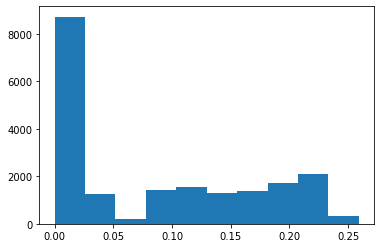

In [22]:
plt.hist(val_set.normed_all_actual_distances.numpy()[:, 0])

## 2. Construct a classifier which classifies based on the closest distance to the spheres.

### 2.1 Compute and store logits from Distance Regressor

In [ ]:
%run -i learn_mfld_distance.py --test --specs ./expt_specs/specs_distlearn_2spheres_expC_test_08062021.json




In [ ]:
print(np.max(train_set.normed_all_actual_distances.numpy()[:, 0]))
print(np.max(train_set.normed_all_distances.numpy()[:, 0]))

print(np.max(train_set.all_actual_distances.numpy()[:, 0]))
print(np.max(train_set.all_distances.numpy()[:, 0]))

print(np.max(train_set.all_actual_distances.numpy()[:, 0]) / train_set.norm_factor)
print(np.max(train_set.all_distances.numpy()[:, 0]) / train_set.norm_factor)

### 2.2 Compute predicted labels based on closest sphere to all the points

In [ ]:
def argmin_dist_clf(inputs, targets, class_labels, off_mfld_lbl=2):
    """
        argmin distance based clf for on-manifold points

        (currently coded only for at most two spheres)

        
        :param inputs: logits obtained from a distance regressor
        :type inputs: torch.Tensor 
        :param targets: actual values of distances
        :type targets: torch.Tensor
        :param class_labels: class labels from the dataset
        :type class_labels: torch.Tensor
        :param off_mfld_lbl: label for off manifold samples
        :type off_mfld_lbl: int
        :return: minimum and argmin of predicted and target distances
        :rtype: (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)
    """
    
    OFF_MFLD_LBL = off_mfld_lbl
    # selecting on-manifold points for further computations
    on_mfld_targets = targets[class_labels != OFF_MFLD_LBL]
    on_mfld_inputs = inputs[class_labels != OFF_MFLD_LBL]
    
    min_pred_dist, pred_argmin = torch.min(on_mfld_inputs, axis=1)
    min_true_dist, true_argmin = torch.min(on_mfld_targets, axis=1)

    print(classification_report(true_argmin, pred_argmin, target_names=["S1", "S2"]))

    return min_pred_dist, pred_argmin, min_true_dist, true_argmin

    

In [ ]:
logits_fn = "/azuredrive/dumps/expC_dist_learner_for_adv_ex/k2n2/actual_dist_learner_w_masked_mse/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=2;k=2;actual_distance}/10062021-140010/logits/test/logits.pt"
targets_fn = "/azuredrive/dumps/expC_dist_learner_for_adv_ex/k2n2/actual_dist_learner_w_masked_mse/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=2;k=2;actual_distance}/10062021-140010/logits/test/targets.pt"

dataset_fn = "/azuredrive/datasets/expC/2spheres_k2n2/test_set.pt"

logits = torch.load(logits_fn)
targets = torch.load(targets_fn)
dataset = torch.load(dataset_fn)



In [ ]:
class_labels = dataset.class_labels



In [ ]:
_, pred_classes, _, true_classes = argmin_dist_clf(logits, targets, class_labels)



### 2.3 Visualizing the boundary of the `argmin`-based distance clf

In [7]:
# Visualizing the decision boundary

# indices to plot the decision boundary for
x_idx, y_idx = 0, 1


INPUT_SIZE = 2
NUM_CLASSES = 2

# load the model
model_fn = "/azuredrive/dumps/expC_dist_learner_for_adv_ex/k2n2/actual_dist_learner_w_masked_mse/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=2;k=2;actual_distance}/10062021-140010/models/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=2;k=2;actual_distance}_10062021-140010_val_loss_5.50927297560122e-08_epoch_497.pth"
# model_fn = "/azuredrive/dumps/expC_dist_learner_for_adv_ex/k2n2/dist_learner/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=100;k=2}/07062021-050120/models/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=100;k=2}_07062021-050120_val_loss_2.531593505494811e-07_epoch_498.pth"
# model = MLPwithNormalisation(input_size=INPUT_SIZE, output_size=NUM_CLASSES, hidden_sizes=[512] * 4, weight_norm=False, use_tanh=False, use_relu=False)
# model.load_state_dict(torch.load(model_fn)["model_state_dict"])


# generate a dataset over the sample space
BATCH_SIZE = 512
NUM_WORKERS = 8

dataset = train_set

generated_data = torch.from_numpy(np.random.uniform(low=torch.min(dataset.normed_all_points) - 0.01, high=torch.max(dataset.normed_all_points) + 0.01, size=(100000, 2))).float()
# generated_data = torch.from_numpy(np.random.uniform(low=0, high=1, size=(100000, 2))).float()

# generated_data = torch.from_numpy(np.random.normal(loc=0.5, scale=1e-3, size=(100000, 100))).float()

dummy_labels = torch.from_numpy(np.zeros((100000, 2))).float()
generated_dataset = TensorDataset(generated_data, dummy_labels)
dataloader = DataLoader(dataset=generated_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# misc. but needed
CUDA = 0
device = torch.device("cuda:{}".format(CUDA) if torch.cuda.is_available() and CUDA else "cpu")

# computing the logits on the generated dataset
_, _, _, generated_logits = test(model, dataloader, device, feature_name="normed_points",\
                                 target_name="normed_actual_distances") 





name: data
MSE for the learned distances: 0.0032547116
MSE for the learned distances (on-manifold): 0.0032547275


In [ ]:
pred_distances_for_offmfld_pts_of_S1 = generated_logits[np.linalg.norm(generated_data - dataset.S1.normed_x_cn, ord=2, axis=1) > ((dataset.S1.r + dataset.S1.D) / dataset.norm_factor)][:,0]

plt.hist(pred_distances_for_offmfld_pts_of_S1.numpy())
plt.show()

min(pred_distances_for_offmfld_pts_of_S1)


In [ ]:
dataset.S1.D / dataset.norm_factor, dataset.S1.r / dataset.norm_factor

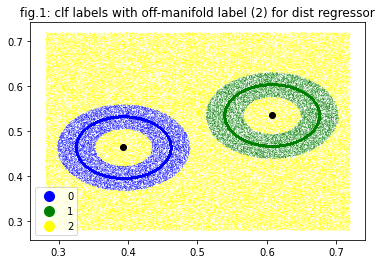

(100000, 2)


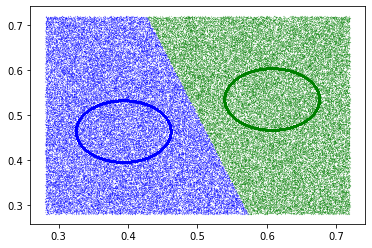

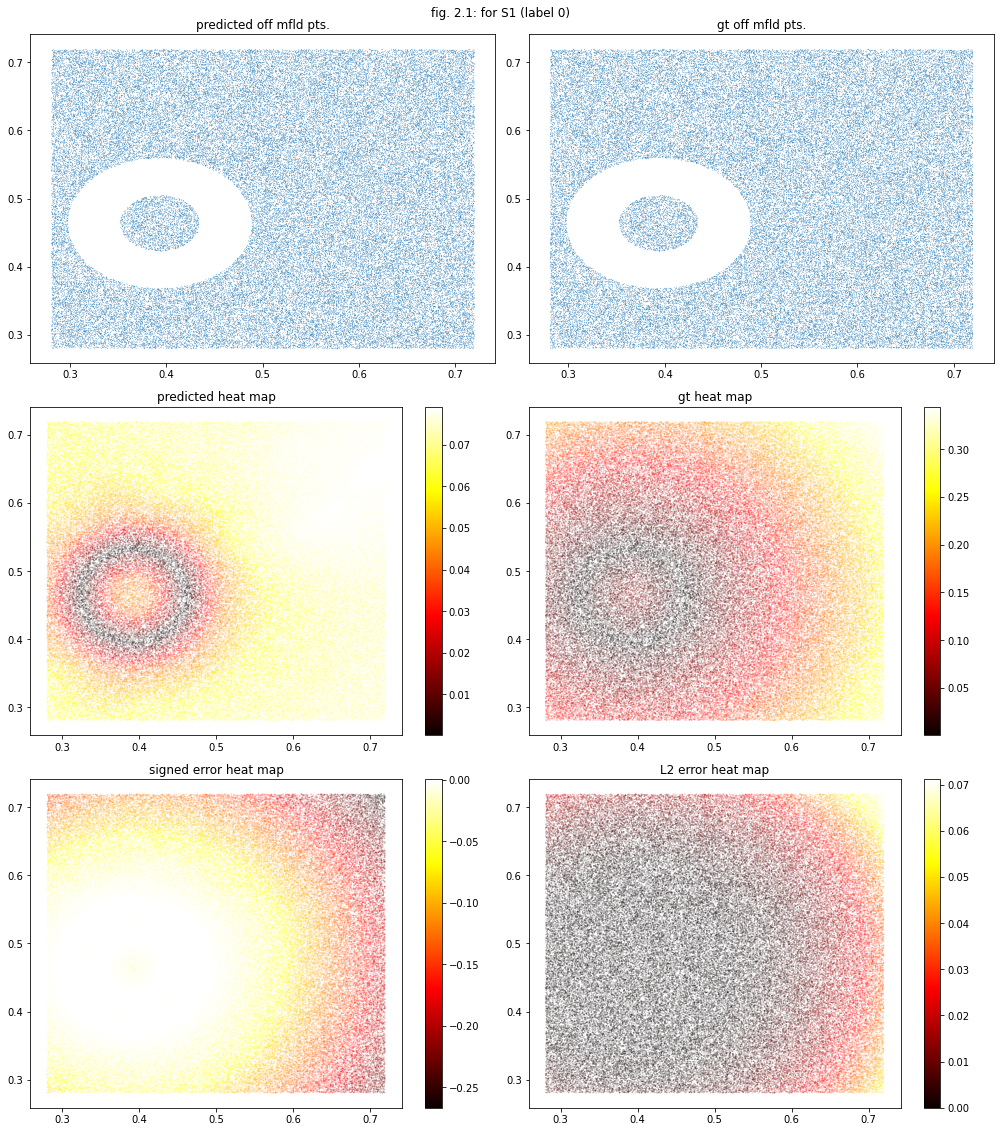

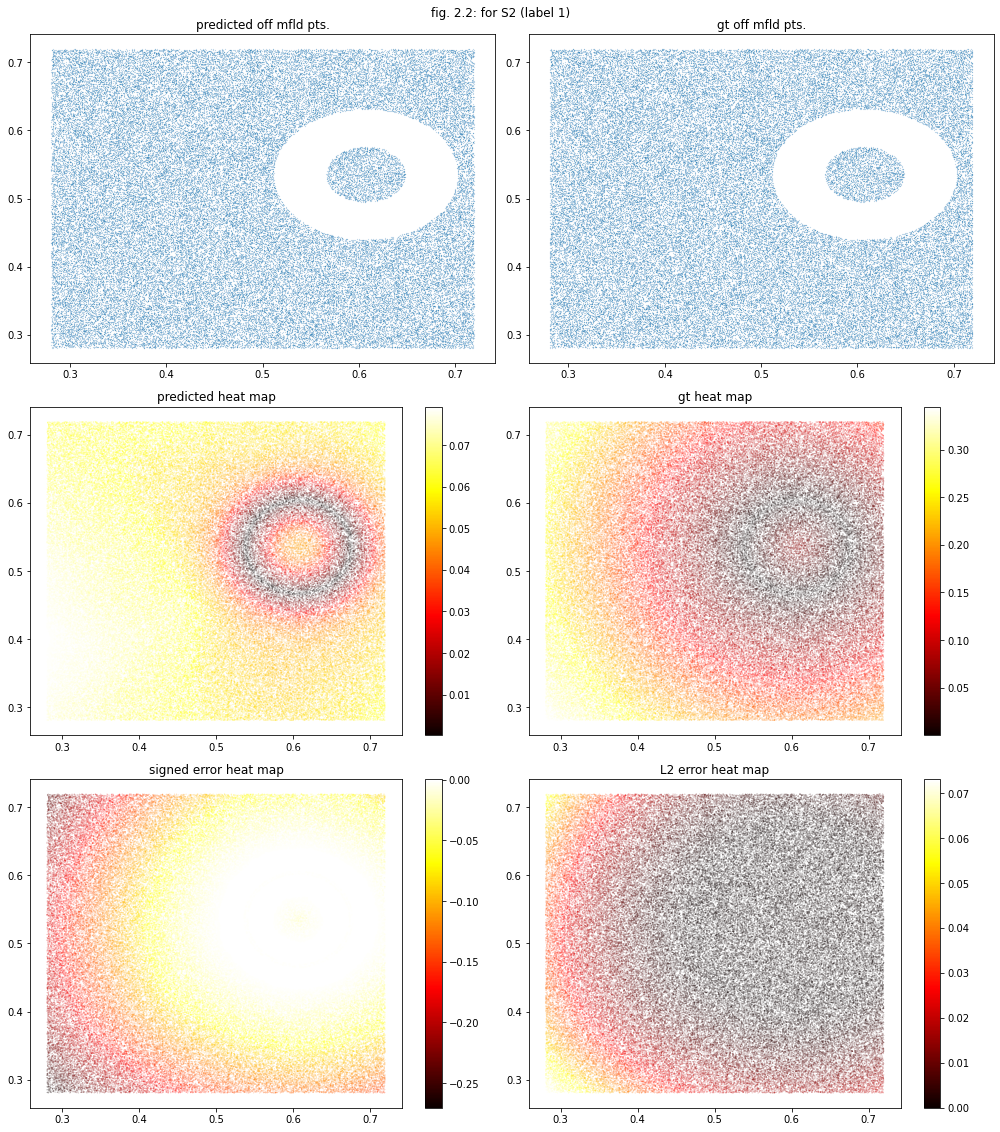

In [8]:
gen_pred_classes = torch.min(generated_logits, axis=1)[1]
# to mark off-manifold points
OFF_MFLD_LABEL = 2
THRESH = dataset.S1.D / dataset.norm_factor
# THRESH = 0.02
gen_pred_classes[torch.min(generated_logits, axis=1)[0] >= THRESH] = OFF_MFLD_LABEL

gt_dists = None


        
col = ["blue", "yellow"]
col = ["blue", "green", "yellow"]

for i in range(len(col)):
    plt.scatter(generated_data[gen_pred_classes.numpy() == i, x_idx].numpy(), generated_data[gen_pred_classes.numpy() == i, y_idx].numpy(), s=0.01, c=col[i], label=i)
    if (i < 2):
        plt.scatter(dataset.normed_all_points[dataset.class_labels == i, x_idx].numpy(), dataset.normed_all_points[dataset.class_labels == i, y_idx].numpy(), c=col[i], s=0.1)

x_min, x_max = 0.3, 0.4
y_min, y_max = 0.6, 0.7
    
# observe = generated_data[(generated_data[:, 1] > y_min) & (generated_data[:, 1] < y_max) &\
#               (generated_data[:, 0] > x_min) & (generated_data[:, 0] < x_max)]
# plt.scatter(observe[:, 0], observe[:, 1])

plt.scatter(dataset.S1.normed_x_cn[0], dataset.S1.normed_x_cn[1], c="black")
plt.scatter(dataset.shifted_S2.normed_x_cn[0], dataset.shifted_S2.normed_x_cn[1], c="black")


plt.legend(markerscale=100)
plt.title("fig.1: clf labels with off-manifold label (2) for dist regressor")
plt.show()

sphere_objects = [dataset.S1, dataset.shifted_S2]

for i in range(len(sphere_objects)):
    if gt_dists is None:
        gt_dists = np.abs(np.linalg.norm(generated_data - sphere_objects[i].normed_x_cn, ord=2, axis=1) - (sphere_objects[i].r/dataset.norm_factor))
    else:
        tmp = np.abs(np.linalg.norm(generated_data - sphere_objects[i].normed_x_cn, ord=2, axis=1) - (sphere_objects[i].r/dataset.norm_factor))
        gt_dists = np.vstack((gt_dists, tmp))

gt_dists = gt_dists.T
print(gt_dists.shape)
gt_labels = torch.min(torch.from_numpy(gt_dists), axis=1)[1]

for i in range(len(col)):
    plt.scatter(generated_data[gt_labels.numpy() == i, x_idx].numpy(), generated_data[gt_labels.numpy() == i, y_idx].numpy(), s=0.01, c=col[i], label=i)
    if (i < 2):
        plt.scatter(dataset.normed_all_points[dataset.class_labels == i, x_idx].numpy(), dataset.normed_all_points[dataset.class_labels == i, y_idx].numpy(), c=col[i], s=0.1)

plt.show()

for i in range(len(sphere_objects)):
    
    fig, axs = plt.subplots(3, 2, figsize=(14, 16))
    
    axs[0, 0].scatter(generated_data[generated_logits[:, i] >= sphere_objects[i].D / dataset.norm_factor][:, 0],\
               generated_data[generated_logits[:, i] >= sphere_objects[i].D / dataset.norm_factor][:, 1], s=0.01)
    axs[0, 0].set_title("predicted off mfld pts.")

    axs[0, 1].scatter(generated_data[np.abs(np.linalg.norm(generated_data - sphere_objects[i].normed_x_cn, ord=2, axis=1) - sphere_objects[i].r / dataset.norm_factor) >= sphere_objects[i].D / dataset.norm_factor][:, 0],\
               generated_data[np.abs(np.linalg.norm(generated_data - sphere_objects[i].normed_x_cn, ord=2, axis=1) - sphere_objects[i].r / dataset.norm_factor) >= sphere_objects[i].D / dataset.norm_factor][:, 1], s=0.01)
    axs[0, 1].set_title("gt off mfld pts.".format(a=i+1, b=i))
    
    sc1 = axs[1, 0].scatter(generated_data[:, 0], generated_data[:, 1], s=0.01, c=generated_logits[:, i], cmap="hot")
    fig.colorbar(sc1, ax=axs[1, 0])
    axs[1, 0].set_title("predicted heat map")

    
#     gt_dist = np.clip(np.abs(np.linalg.norm(generated_data - sphere_objects[i].normed_x_cn, ord=2, axis=1) - (sphere_objects[i].r/dataset.norm_factor)), 0, sphere_objects[i].D / dataset.norm_factor)
    gt_dist = np.abs(np.linalg.norm(generated_data - sphere_objects[i].normed_x_cn, ord=2, axis=1) - (sphere_objects[i].r/dataset.norm_factor))
    
    sc2 = axs[1, 1].scatter(generated_data[:, 0], generated_data[:, 1], s=0.01, c=gt_dist, cmap="hot")
    fig.colorbar(sc2, ax=axs[1, 1])
    axs[1, 1].set_title("gt heat map")
    
    
    sc3 = axs[2, 0].scatter(generated_data[:, 0], generated_data[:, 1], s=0.01, c=(generated_logits[:, i] - gt_dist), cmap="hot")
    fig.colorbar(sc3, ax=axs[2, 0])
    axs[2, 0].set_title("signed error heat map")
    
    
    sc4 = axs[2, 1].scatter(generated_data[:, 0], generated_data[:, 1], s=0.01, c=(generated_logits[:, i] - gt_dist)**2, cmap="hot")
    fig.colorbar(sc4, ax=axs[2, 1])
    axs[2, 1].set_title("L2 error heat map")
        
    
    fig.suptitle("fig. 2.{a}: for S{a} (label {b})".format(a=i+1, b=i))
    fig.tight_layout()
    
plt.show()

In [ ]:
fig, axs = plt.subplots(3, figsize=(10, 8))

axs[0].hist(np.linalg.norm(generated_data[(generated_data[:, 1] > y_min) & (generated_data[:, 1] < y_max) &\
              (generated_data[:, 0] > x_min) & (generated_data[:, 0] < x_max)] - dataset.S1.normed_x_cn, ord=2, axis=1) - (dataset.S1.r/dataset.norm_factor))
axs[0].set_title("gt")

axs[1].hist(torch.min(generated_logits[(generated_data[:, 1] > y_min) & (generated_data[:, 1] < y_max) &\
              (generated_data[:, 0] > x_min) & (generated_data[:, 0] < x_max)], axis=1)[0].numpy())
axs[1].set_title("min")

axs[2].hist(torch.max(generated_logits[(generated_data[:, 1] > y_min) & (generated_data[:, 1] < y_max) &\
              (generated_data[:, 0] > x_min) & (generated_data[:, 0] < x_max)], axis=1)[0].numpy())
axs[2].set_title("max")
fig.suptitle("fig. 3: distribution of predicted and ground truth distances from S1 in shaded region in fig. 1")
fig.tight_layout()
plt.show()

## 3. Compare this to a standard classifier which learns the classification task directly (instead of learning distance functions).

### 3.1 Train a standard classifier on the same dataset

In [ ]:
# %run -i learn_mfld_distance.py --train --specs ./expt_specs/specs_stdclf_2spheres_expC_train_07062021.json




### 3.2 Compute and store logits for standard classification

In [ ]:
%run -i learn_mfld_distance.py --test --specs ./expt_specs/specs_stdclf_2spheres_expC_test_07062021.json


### 3.3 Visualization of Decision Regions for standard classifier

In [ ]:
# Visualizing the decision boundary

# indices to plot the decision boundary for
x_idx, y_idx = 0, 1

INPUT_SIZE = 2
NUM_CLASSES = 2

# load the model
model_fn = "/azuredrive/dumps/expC_dist_learner_for_adv_ex/k2n2/std_clf/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm,clf}_data{2spheres_in_unit_cube;n=2;k=2}/07062021-072632/models/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm,clf}_data{2spheres_in_unit_cube;n=2;k=2}_07062021-072632_val_loss_0.6298815727233886_epoch_2.pth"
model = MLPwithNormalisation(input_size=INPUT_SIZE, output_size=NUM_CLASSES, hidden_sizes=[512] * 4, weight_norm=False, use_tanh=False, use_relu=False)
model.load_state_dict(torch.load(model_fn)["model_state_dict"])


# generate a dataset over the sample space
BATCH_SIZE = 512
NUM_WORKERS = 8

generated_data = torch.from_numpy(np.random.uniform(low=torch.min(dataset.normed_all_points) - 0.01, high=torch.max(dataset.normed_all_points) + 0.01, size=(100000, 2))).float()
# generated_data = torch.from_numpy(np.random.normal(loc=0.5, scale=1e-3, size=(100000, 100))).float()

dummy_labels = torch.from_numpy(np.zeros(100000)).float()
generated_dataset = TensorDataset(generated_data, dummy_labels)
dataloader = DataLoader(dataset=generated_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# misc. but needed
CUDA = 0
device = torch.device("cuda:{}".format(CUDA) if torch.cuda.is_available() and CUDA else "cpu")

TASK = "clf"
FEAT_NAME = "normed_points"
TGT_NAME = "classes"


# computing the logits on the generated dataset
_, _, _, generated_logits = test(model, dataloader, device, task=TASK, feature_name=FEAT_NAME, target_name=TGT_NAME) 

In [ ]:
gen_pred_classes = torch.max(generated_logits, axis=1)[1]

plt.scatter(generated_data[:, x_idx].numpy(), generated_data[:, y_idx].numpy(), c=gen_pred_classes.numpy(), s=0.01, cmap=matplotlib.cm.cool)

OFF_MFLD_LBL = 2
plt.scatter(dataset.normed_all_points[dataset.class_labels != OFF_MFLD_LBL, x_idx].numpy(), dataset.normed_all_points[dataset.class_labels != OFF_MFLD_LBL, y_idx].numpy(), c=dataset.class_labels[dataset.class_labels != OFF_MFLD_LBL], cmap=matplotlib.cm.cool, s=0.1)
plt.show()


### 3.4 Compare performance for Standard classifier 

We can see from the above results in 3.2 and 2.2 that both the standard classifier and the `argmin`-distance-based classifiers perform equally well for manifold classification.

In order to stress-test and compare these two setups, we add **random gaussian noise to the inputs** and see how well the models take that.


In [ ]:
# Load data
data_fns = {
    "train": "/azuredrive/datasets/expC/2spheres/train_set.pt",
    "val": "/azuredrive/datasets/expC/2spheres/val_set.pt",
    "test": "/azuredrive/datasets/expC/2spheres/test_set.pt"
}

INPUT_SIZE = 2
NUM_CLASSES = 2

dr_model_fn = "/azuredrive/dumps/expC_dist_learner_for_adv_ex/dist_learner/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=100;k=2}/31052021-192633/models/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;n=100;k=2}_31052021-192633_val_loss_9.026023826663732e-06_epoch_499.pth"
dr_model = MLPwithNormalisation(input_size=INPUT_SIZE, output_size=NUM_CLASSES, hidden_sizes=[512] * 4, weight_norm=False, use_tanh=False, use_relu=False)
dr_model.load_state_dict(torch.load(dr_model_fn)["model_state_dict"])

sc_model_fn = "/azuredrive/dumps/expC_dist_learner_for_adv_ex/std_clf/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm,clf}_data{2spheres_in_unit_cube;n=100;k=2}/01062021-172847/models/test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm,clf}_data{2spheres_in_unit_cube;n=100;k=2}_01062021-172847_val_loss_0.6836836189031601_epoch_2.pth"
sc_model = MLPwithNormalisation(input_size=INPUT_SIZE, output_size=NUM_CLASSES, hidden_sizes=[512] * 4, weight_norm=False, use_tanh=False, use_relu=False)
sc_model.load_state_dict(torch.load(sc_model_fn)["model_state_dict"])


BATCH_SIZE = 512

NUM_WORKERS = 8

CUDA = 0
device = torch.device("cuda:{}".format(CUDA) if torch.cuda.is_available() and CUDA else "cpu")



for split in ["train", "val", "test"]:
    
    dataset = torch.load(data_fns[split])

    # Add Gaussian noise
    STDDEV = 1e-1
    MU = 0
    
#     scale = 1e-3
    noise = np.random.normal(MU, STDDEV, size=dataset.normed_all_points.shape[1])
#     noise = scale * (noise / np.linalg.norm(noise, ord=2))
    dataset.normed_all_points = (dataset.normed_all_points + noise).float()
    print("noise scale:", np.linalg.norm(noise, ord=2))
    

    ## for distance regressor
    print("distance regressor; split:", split)
    # Compute logits
    
    dataloader = DataLoader(dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    _, _, targets, generated_logits = test(dr_model, dataloader, device) 
    class_labels = dataset.class_labels
    
    # Compute performance
    _, pred_classes, _, true_classes = argmin_dist_clf(generated_logits, targets, class_labels)
    
    
    ## for standard classifier
    print("standard classifier; split:", split)
    
    OFF_MFLD_LABEL = 2

    dataset.all_points = dataset.all_points[dataset.class_labels != OFF_MFLD_LABEL]
    dataset.all_distances = dataset.all_distances[dataset.class_labels != OFF_MFLD_LABEL]
    dataset.normed_all_points = dataset.normed_all_points[dataset.class_labels != OFF_MFLD_LABEL]
    dataset.normed_all_distances = dataset.normed_all_distances[dataset.class_labels != OFF_MFLD_LABEL]
    dataset.class_labels = dataset.class_labels[dataset.class_labels != OFF_MFLD_LABEL]

    
    # Compute logits
    
    dataloader = DataLoader(dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    _, _, targets, generated_logits = test(sc_model, dataloader, device, task="clf", feature_name="normed_points", target_name="classes", name="std. clf") 
    class_labels = dataset.class_labels

    # Compute performance
    ## already done